In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mne
import matplotlib.style
import os
import pickle
from functools import partial
from math import ceil
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [3]:
unique_main_disorder = df['main.disorder'].unique()
unique_specific_disorder = df['specific.disorder'].unique()

print("Unique values in 'main.disorder':", unique_main_disorder)
print("Unique values in 'specific.disorder':", unique_specific_disorder)

Unique values in 'main.disorder': ['Addictive disorder' 'Trauma and stress related disorder' 'Mood disorder'
 'Healthy control' 'Obsessive compulsive disorder' 'Schizophrenia'
 'Anxiety disorder']
Unique values in 'specific.disorder': ['Alcohol use disorder' 'Acute stress disorder' 'Depressive disorder'
 'Healthy control' 'Behavioral addiction disorder'
 'Obsessive compulsitve disorder' 'Schizophrenia' 'Panic disorder'
 'Social anxiety disorder' 'Posttraumatic stress disorder'
 'Adjustment disorder' 'Bipolar disorder']


In [4]:
df = df.drop(columns=['Unnamed: 122'])

# For simplicity, let's fill missing values in 'education' and 'IQ' with their median values
df['education'].fillna(df['education'].median(), inplace=True)
df['IQ'].fillna(df['IQ'].median(), inplace=True)


In [5]:
# Summary statistics for demographic variables
demographic_summary_cleaned = df[['sex', 'age', 'education', 'IQ']].describe()

# Distribution of the main disorder
main_disorder_distribution_cleaned = df['main.disorder'].value_counts()

print(demographic_summary_cleaned)
print(main_disorder_distribution_cleaned)


              age   education          IQ
count  945.000000  945.000000  945.000000
mean    30.594804   13.431746  101.586243
std     11.781592    2.530711   16.904869
min     18.000000    0.000000   49.000000
25%     21.730000   12.000000   91.000000
50%     26.150000   13.000000  102.000000
75%     35.450000   16.000000  114.000000
max     71.880000   20.000000  145.000000
main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64


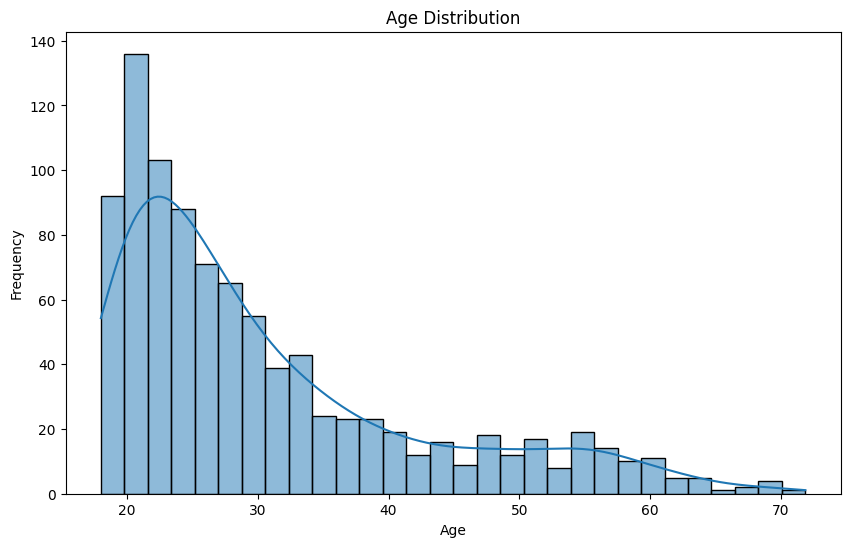

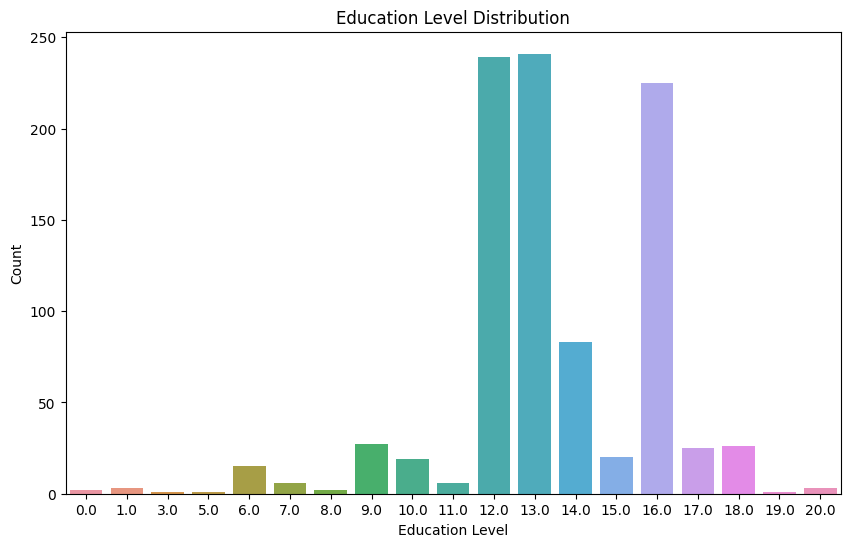

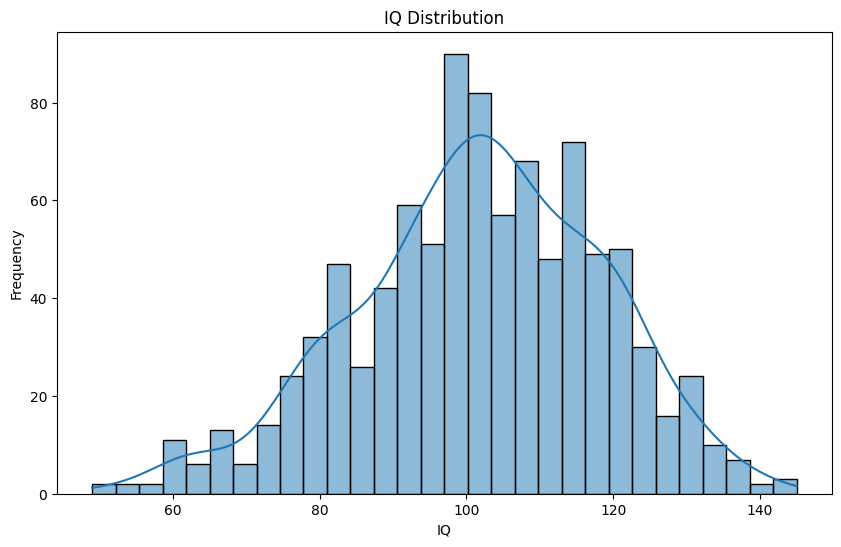

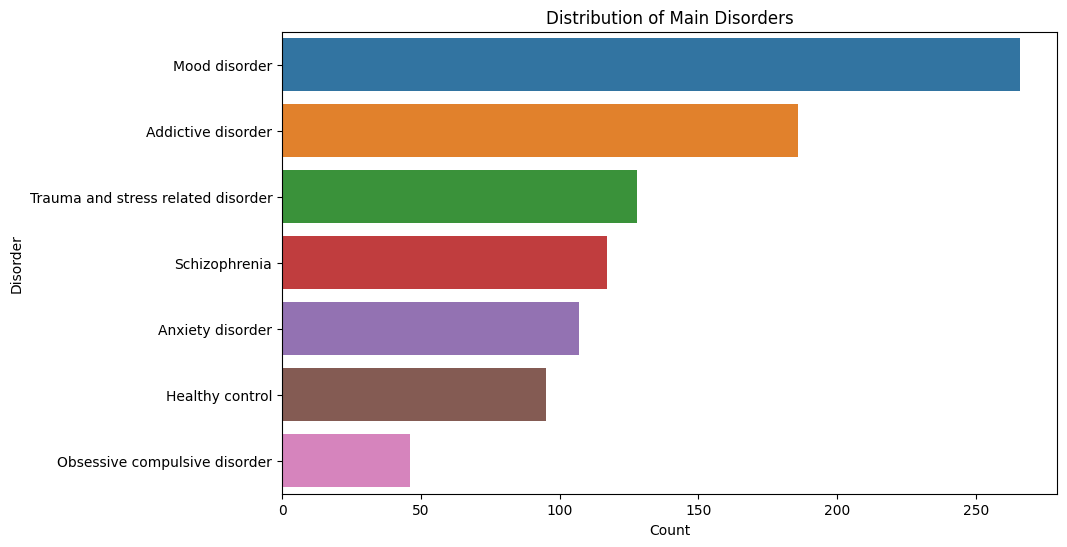

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Education distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=df)
plt.title('Education Level Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

# IQ distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['IQ'], bins=30, kde=True)
plt.title('IQ Distribution')
plt.xlabel('IQ')
plt.ylabel('Frequency')
plt.show()

# Distribution of main disorder
plt.figure(figsize=(10, 6))
sns.countplot(y='main.disorder', data=df, order = df['main.disorder'].value_counts().index)
plt.title('Distribution of Main Disorders')
plt.xlabel('Count')
plt.ylabel('Disorder')
plt.show()

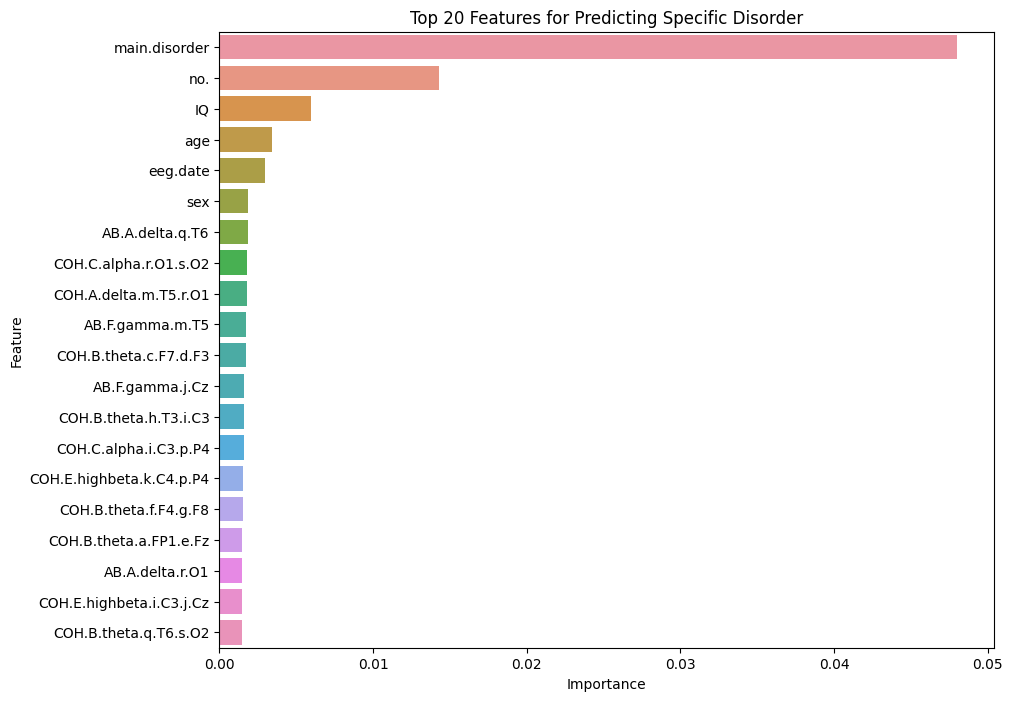

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'specific.disorder' is the target

# Encode categorical variables
df_encoded = df.apply(LabelEncoder().fit_transform)

# Separating features and target
X = df_encoded.drop('specific.disorder', axis=1)  # Features
y = df_encoded['specific.disorder']  # Target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame to discover the most important features
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visualize the top N feature importances
top_n = 20  # You can adjust this number
top_features = feature_importances.head(top_n)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title(f'Top {top_n} Features for Predicting Specific Disorder')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [8]:
sns.set_style('whitegrid')

Renaming some of the columns:
XX.X.band.x.channel to band.channel
COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2

In [9]:
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel or 
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result
df.rename(reformat_name, axis=1)
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,13.0,102.0,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


# Exploratory data analysis
Data includes:
- patients' information
    - no. - patients unique id
    - sex - M (male) or F (female)
    - age
    - eeg.date - date of EEG
    - education - years of educations
    - IQ - intelligence quotient
- diagnosis
    - main.disorder
    - specific.disorder
- QEEG PSD (power spectrum density) -  absolute power value in each frequency band
- QEEG FC (functional connectivity) - coherence for each band and channel  

Extract information with patients' information only:

In [10]:
patients_info = df.loc[:,'sex':'specific.disorder']
patients_info

,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder
0,M,57.0,2012.8.30,13.0,102.0,Addictive disorder,Alcohol use disorder
1,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder
2,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder
3,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder
4,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder
...,...,...,...,...,...,...,...
940,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control
941,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control
942,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control
943,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control


In [11]:
countplot = partial(sns.countplot, data=patients_info)
countplots = partial(sns.catplot, data=patients_info, kind='count', col_wrap=3)

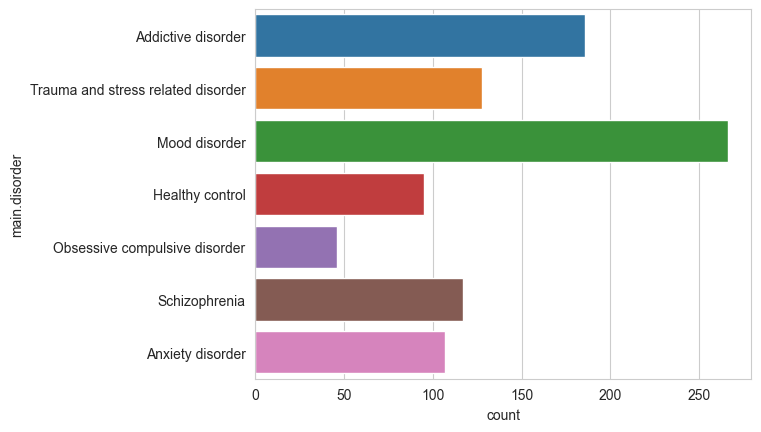

In [12]:
countplot(y='main.disorder')
plt.show()

main.disorder                       specific.disorder             
Trauma and stress related disorder  Acute stress disorder              38
                                    Adjustment disorder                38
Obsessive compulsive disorder       Obsessive compulsitve disorder     46
Anxiety disorder                    Social anxiety disorder            48
Trauma and stress related disorder  Posttraumatic stress disorder      52
Anxiety disorder                    Panic disorder                     59
Mood disorder                       Bipolar disorder                   67
Addictive disorder                  Alcohol use disorder               93
                                    Behavioral addiction disorder      93
Healthy control                     Healthy control                    95
Schizophrenia                       Schizophrenia                     117
Mood disorder                       Depressive disorder               199
dtype: int64

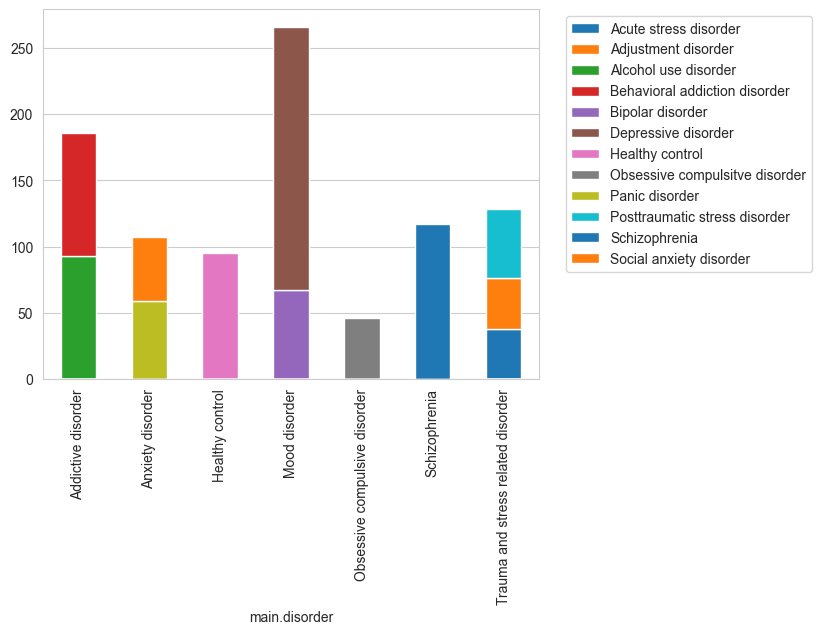

In [13]:
fig,ax = plt.subplots()
disorder_counts = df.groupby(['main.disorder', 'specific.disorder']).size()
display(disorder_counts.sort_values())
disorder_counts.unstack('specific.disorder')\
    .plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.xaxis.grid(False)
plt.show()

We can see class disbalances. The most noticeable are:
1. Obsessive compulsive disorder
2. Depressive disorder

In [14]:
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,13.0,102.0,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [15]:
df2 = df.drop(['no.', 'eeg.date','main.disorder'],axis= 1)

In [32]:
df2.head()

,sex,age,education,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,M,57.0,13.0,102.0,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,M,37.0,6.0,120.0,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,M,32.0,16.0,113.0,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,M,35.0,18.0,126.0,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,M,36.0,16.0,112.0,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


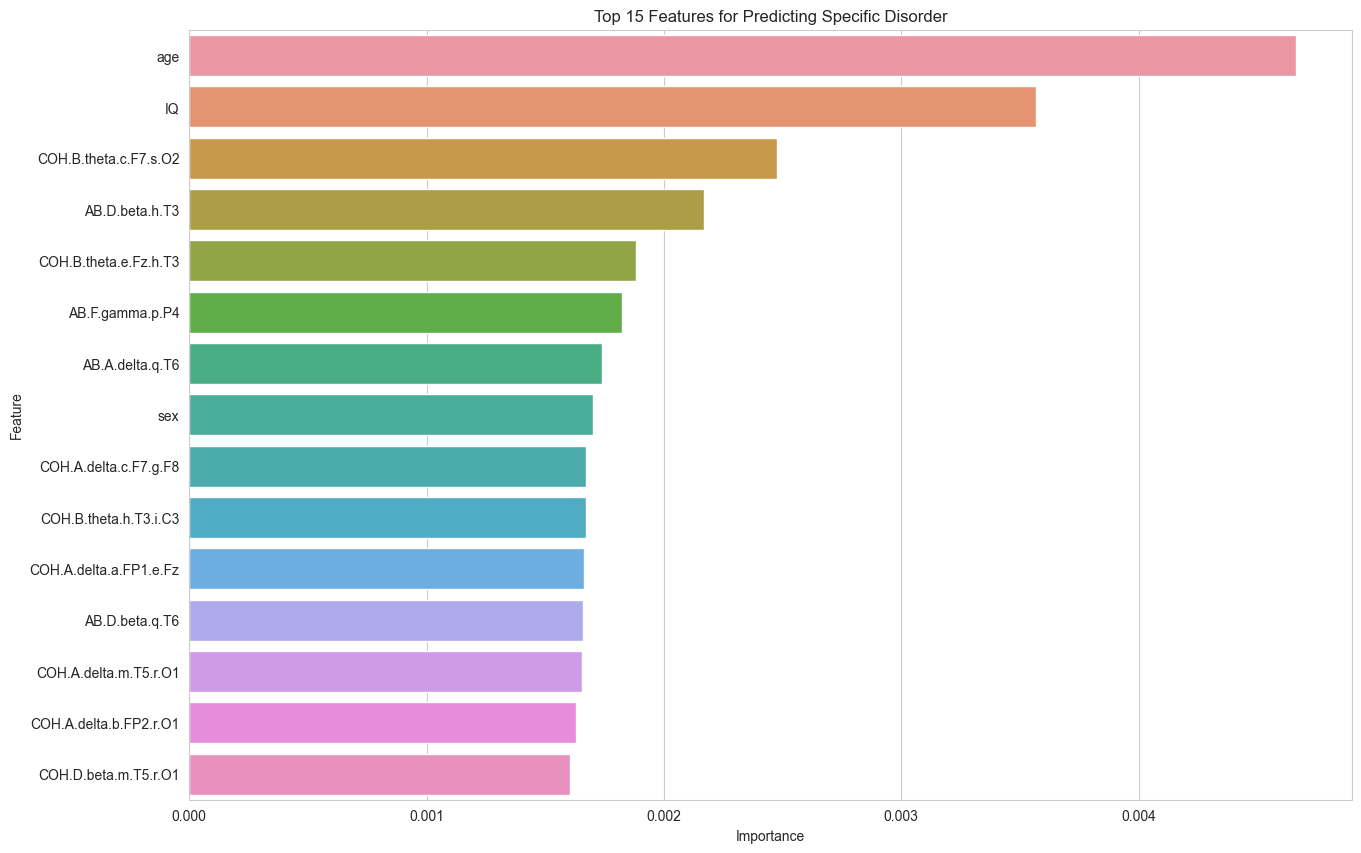

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and 'specific.disorder' is the target

# Create a copy of the DataFrame to avoid modifying the original
df_encoded = df2.copy()

# Encode 'specific.disorder' and 'sex' columns
label_encoder = LabelEncoder()
df_encoded['specific.disorder'] = label_encoder.fit_transform(df_encoded['specific.disorder'])
df_encoded['sex'] = label_encoder.fit_transform(df_encoded['sex'])

# Separating features and target
X = df_encoded.drop('specific.disorder', axis=1)  # Features
y = df_encoded['specific.disorder']  # Target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame to discover the most important features
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visualize the top N feature importances
top_n = 15  # You can adjust this number
top_features = feature_importances.head(top_n)
plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title(f'Top {top_n} Features for Predicting Specific Disorder')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [42]:
df_encoded

,sex,age,education,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,57.0,13.0,102.0,2,35.998557,21.717375,21.518280,26.825048,26.611516,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,1,37.0,6.0,120.0,2,13.425118,11.002916,11.942516,15.272216,14.151570,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,1,32.0,16.0,113.0,2,29.941780,27.544684,17.150159,23.608960,27.087811,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,1,35.0,18.0,126.0,2,21.496226,21.846832,17.364316,13.833701,14.100954,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,1,36.0,16.0,112.0,2,37.775667,33.607679,21.865556,21.771413,22.854536,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,1,22.0,13.0,116.0,6,41.851823,36.771496,43.671792,36.860889,24.732236,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,1,26.0,13.0,118.0,6,18.986856,19.401387,27.586436,20.194732,19.407491,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,1,26.0,16.0,113.0,6,28.781317,32.369230,11.717778,23.134370,26.209302,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,1,24.0,13.0,107.0,6,19.929100,25.196375,14.445391,16.453456,16.590649,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [43]:
df_top_15 = df_encoded[top_features['feature'].tolist() + ['specific.disorder']]

In [44]:
df_top_15.head()

,age,IQ,COH.B.theta.c.F7.s.O2,AB.D.beta.h.T3,COH.B.theta.e.Fz.h.T3,AB.F.gamma.p.P4,AB.A.delta.q.T6,sex,COH.A.delta.c.F7.g.F8,COH.B.theta.h.T3.i.C3,COH.A.delta.a.FP1.e.Fz,AB.D.beta.q.T6,COH.A.delta.m.T5.r.O1,COH.A.delta.b.FP2.r.O1,COH.D.beta.m.T5.r.O1,specific.disorder
0,57.0,102.0,13.287196,9.509544,25.413546,1.552658,11.777727,1,7.535500,37.957957,49.858714,7.637561,6.649964,1.768346,29.004740,2
1,37.0,120.0,1.385417,17.907382,44.553457,1.411808,8.538482,1,17.223035,66.519684,72.895431,15.053848,42.904301,0.759446,54.777796,2
2,32.0,113.0,2.122098,7.411332,40.766287,1.349457,11.242449,1,21.192762,69.674684,77.045829,6.512094,28.650796,1.134033,37.285972,2
3,35.0,126.0,0.216440,4.271065,43.030072,1.131654,10.612230,1,8.760590,44.763042,44.577578,4.967585,28.080981,0.598372,61.288608,2
4,36.0,112.0,6.004198,6.512581,27.862966,2.350806,19.541089,1,7.228875,36.004902,65.225754,22.979801,14.206784,8.811959,73.841334,2


In [45]:
column_data_types = df_top_15.dtypes

# Display the data types of each column
print(column_data_types)

age                       float64
IQ                        float64
COH.B.theta.c.F7.s.O2     float64
AB.D.beta.h.T3            float64
COH.B.theta.e.Fz.h.T3     float64
AB.F.gamma.p.P4           float64
AB.A.delta.q.T6           float64
sex                         int32
COH.A.delta.c.F7.g.F8     float64
COH.B.theta.h.T3.i.C3     float64
COH.A.delta.a.FP1.e.Fz    float64
AB.D.beta.q.T6            float64
COH.A.delta.m.T5.r.O1     float64
COH.A.delta.b.FP2.r.O1    float64
COH.D.beta.m.T5.r.O1      float64
specific.disorder           int32
dtype: object


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare the data
X_new = df_top_15.drop('specific.disorder', axis=1)
y_new = df_top_15['specific.disorder']

# Split the data into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Initialize and train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_new, y_train_new)

# Make predictions
predictions = classifier.predict(X_test_new)

# Evaluate the model
accuracy = accuracy_score(y_test_new, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test_new, predictions))


Accuracy: 0.291005291005291
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        10
           2       0.31      0.26      0.29        19
           3       0.25      0.33      0.29        15
           4       0.17      0.08      0.11        12
           5       0.30      0.57      0.39        44
           6       0.56      0.53      0.54        19
           7       0.17      0.11      0.13         9
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00        18
          10       0.24      0.40      0.30        20
          11       0.00      0.00      0.00         9

    accuracy                           0.29       189
   macro avg       0.17      0.19      0.17       189
weighted avg       0.22      0.29      0.24       189



C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Assuming 'df_selected_features' is the DataFrame with the top 15 features already selected
X = df_top_15.drop('specific.disorder', axis=1)  # Features
y = df_top_15['specific.disorder']  # Target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Classifier with basic hyperparameters
# Note: For a real project, consider tuning these parameters
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model on the training data
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Note: For hyperparameter tuning, consider using GridSearchCV or RandomizedSearchCV here


Accuracy: 25.40%


In [48]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Assuming 'df_selected_features' is the DataFrame with the top 15 features and target variable
X = df_top_15.drop('specific.disorder', axis=1)  # Features
y = df_top_15['specific.disorder']  # Target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Setup the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(xgb, param_grid, n_iter=10, scoring='accuracy', cv=4, random_state=42)

# Fit random_cv to the training data
random_cv.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", random_cv.best_params_)
print("Best accuracy found: ", random_cv.best_score_)

# Use the best estimator to make predictions on the test set
best_model = random_cv.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr', average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')


Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best accuracy found:  0.2724867724867725
Accuracy: 30.69%
F1 Score: 0.25
Precision: 0.24
Recall: 0.31
ROC AUC Score: 0.71


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
df_top_15

,age,IQ,COH.B.theta.c.F7.s.O2,AB.D.beta.h.T3,COH.B.theta.e.Fz.h.T3,AB.F.gamma.p.P4,AB.A.delta.q.T6,sex,COH.A.delta.c.F7.g.F8,COH.B.theta.h.T3.i.C3,COH.A.delta.a.FP1.e.Fz,AB.D.beta.q.T6,COH.A.delta.m.T5.r.O1,COH.A.delta.b.FP2.r.O1,COH.D.beta.m.T5.r.O1,specific.disorder
0,57.0,102.0,13.287196,9.509544,25.413546,1.552658,11.777727,1,7.535500,37.957957,49.858714,7.637561,6.649964,1.768346,29.004740,2
1,37.0,120.0,1.385417,17.907382,44.553457,1.411808,8.538482,1,17.223035,66.519684,72.895431,15.053848,42.904301,0.759446,54.777796,2
2,32.0,113.0,2.122098,7.411332,40.766287,1.349457,11.242449,1,21.192762,69.674684,77.045829,6.512094,28.650796,1.134033,37.285972,2
3,35.0,126.0,0.216440,4.271065,43.030072,1.131654,10.612230,1,8.760590,44.763042,44.577578,4.967585,28.080981,0.598372,61.288608,2
4,36.0,112.0,6.004198,6.512581,27.862966,2.350806,19.541089,1,7.228875,36.004902,65.225754,22.979801,14.206784,8.811959,73.841334,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,22.0,116.0,13.553198,4.714835,54.143715,1.710518,17.794791,1,6.051601,76.404529,35.610775,6.739795,61.129583,15.509095,61.029165,6
941,26.0,118.0,45.826867,6.169934,67.633932,3.247100,15.223781,1,61.972248,78.858835,84.036930,8.436397,97.490007,66.399858,72.159004,6
942,26.0,113.0,2.557806,3.972070,45.034198,1.644675,7.656321,1,31.596481,54.716249,99.704916,3.858774,90.616347,1.271401,85.805750,6
943,24.0,107.0,1.459998,5.781728,58.750872,1.888551,8.538615,1,46.559046,88.140234,54.386213,4.980263,5.930697,0.842495,36.347321,6


In [50]:
df_top_15.head()

,age,IQ,COH.B.theta.c.F7.s.O2,AB.D.beta.h.T3,COH.B.theta.e.Fz.h.T3,AB.F.gamma.p.P4,AB.A.delta.q.T6,sex,COH.A.delta.c.F7.g.F8,COH.B.theta.h.T3.i.C3,COH.A.delta.a.FP1.e.Fz,AB.D.beta.q.T6,COH.A.delta.m.T5.r.O1,COH.A.delta.b.FP2.r.O1,COH.D.beta.m.T5.r.O1,specific.disorder
0,57.0,102.0,13.287196,9.509544,25.413546,1.552658,11.777727,1,7.535500,37.957957,49.858714,7.637561,6.649964,1.768346,29.004740,2
1,37.0,120.0,1.385417,17.907382,44.553457,1.411808,8.538482,1,17.223035,66.519684,72.895431,15.053848,42.904301,0.759446,54.777796,2
2,32.0,113.0,2.122098,7.411332,40.766287,1.349457,11.242449,1,21.192762,69.674684,77.045829,6.512094,28.650796,1.134033,37.285972,2
3,35.0,126.0,0.216440,4.271065,43.030072,1.131654,10.612230,1,8.760590,44.763042,44.577578,4.967585,28.080981,0.598372,61.288608,2
4,36.0,112.0,6.004198,6.512581,27.862966,2.350806,19.541089,1,7.228875,36.004902,65.225754,22.979801,14.206784,8.811959,73.841334,2


In [51]:
# Extract feature columns (excluding the target column 'specific.disorder')
feature_columns = df_top_15.drop('specific.disorder', axis=1).columns

# Create a DataFrame with the sample input
sample_input_values = [57, 126, 2.122098, 7.411332, 6.512581, 25.413546, 1.411808, 1, 7.228875, 69.674684, 72.895431, 4.967585, 6.512094, 7.637561,61.288608]
sample_input_df = pd.DataFrame([sample_input_values], columns=feature_columns)

# Use the best_model to predict the output
predicted_output = best_model.predict(sample_input_df)

# Output the prediction
print(predicted_output)


[3]


In [52]:
import pandas as pd
from xgboost import XGBClassifier

# Extract feature columns (excluding the target column 'specific.disorder')
feature_columns = df_top_15.drop('specific.disorder', axis=1).columns

# Get user input for sample values
sample_input_values = []
for feature in feature_columns:
    value = input(f"Enter value for {feature}: ")
    sample_input_values.append(float(value))  # Assuming the values are numeric

# Create a DataFrame with the user-input values
sample_input_df = pd.DataFrame([sample_input_values], columns=feature_columns)

# Use the best_model to predict the output
predicted_output = best_model.predict(sample_input_df)

# Output the prediction
print(predicted_output)


[3]


In [59]:
# Define the mapping dictionary
label_mapping = {
    0: 'Alcohol use disorder',
    1: 'Acute stress disorder',
    2: 'Depressive disorder',
    3: 'Healthy control',
    4: 'Behavioral addiction disorder',
    5: 'Obsessive compulsive disorder',
    6: 'Schizophrenia',
    7: 'Panic disorder',
    8: 'Social anxiety disorder',
    9: 'Posttraumatic stress disorder',
    10: 'Adjustment disorder',
    11: 'Bipolar disorder'
}

# Map label-encoded values back to original labels
mapped_predictions = [label_mapping[label] for label in predicted_output]

# Output the predictions
print(mapped_predictions)


['Healthy control']


In [53]:
unique_specific_disorder = df_top_15['specific.disorder'].unique()
print("Unique values in 'specific.disorder':", unique_specific_disorder)


Unique values in 'specific.disorder': [ 2  0  5  6  3  7 10  8 11  9  1  4]


In [54]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Alcohol use disorder' ,'Acute stress disorder', 'Depressive disorder',
 'Healthy control' ,'Behavioral addiction disorder',
 'Obsessive compulsitve disorder', 'Schizophrenia', 'Panic disorder',
 'Social anxiety disorder', 'Posttraumatic stress disorder',
 'Adjustment disorder' ,'Bipolar disorder'])

# Choose a specific instance for explanation (e.g., the first instance in the test set)
instance_idx = 0
instance = X_test.iloc[[instance_idx]].values[0]
true_class = y_test.iloc[instance_idx]

# Explain the prediction
exp = explainer.explain_instance(instance, best_model.predict_proba, num_features=5, top_labels=1)

# Display the explanation
exp.show_in_notebook(show_table=True)

In [55]:
import lime
import lime.lime_tabular

# Initialize the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Alcohol use disorder' ,'Acute stress disorder', 'Depressive disorder',
 'Healthy control' ,'Behavioral addiction disorder',
 'Obsessive compulsitve disorder', 'Schizophrenia', 'Panic disorder',
 'Social anxiety disorder', 'Posttraumatic stress disorder',
 'Adjustment disorder' ,'Bipolar disorder'], 
    mode='classification'
)


In [56]:
instance_index = 1  
instance = np.array(X_test.iloc[instance_index]).reshape(1, -1)

# Generate explanation
exp = explainer.explain_instance(
    data_row=instance[0], 
    predict_fn=best_model.predict_proba
)

# Visualizing the explanation
exp.show_in_notebook(show_table=True, show_all=False)  # Use exp.show_in_notebook() in Jupyter Notebooks
# For non-notebook environments, use:
exp.save_to_file('lime_explanation.html')


In [60]:
import pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print('Model saved as best_model.pkl')


Model saved as best_model.pkl


In [62]:
import joblib
model_filename = 'best_model.pkl'
joblib.dump(best_model, model_filename)
print(f'Model saved as {model_filename}')

Model saved as best_model.pkl
